In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data=np.float64(np.load('MNIST.npy'))
labels=np.float32(np.load('MNIST_labels.npy'))
n=len(data)
p=len(data[0])
for i in range(0,n):
    data[i]=data[i]/255 # The value lie in [0,1]
print (data.shape)

(70000, 784)


In [4]:
#Divide the data into Training, Develop and Test
Training=[]
Develop=[]
Test=[]
TrainLabe1=[]
DevelopLabel=[]
TestLabel=[]

for i in range(0,n):
    rn=np.random.choice(range(1,11),1)[0]
    if rn <= 6:
        Training.append(data[i])
        TrainLabe1.append(labels[i])
    elif rn > 8:
        Develop.append(data[i])
        DevelopLabel.append(labels[i])
    else:
        Test.append(data[i])
        TestLabel.append(labels[i])

In [5]:
a=len(Training)
b=len(Develop)
c=len(Test)

print("The number of data in Training : ",a,"(",round(a/n*100,2),")%")
print("The number of data in Develop  : ",b,"(",round(b/n*100,2),")%")
print("The number of data in Test     : ",c,"(",round(c/n*100,2),")%")

The number of data in Training :  42101 ( 60.14 )%
The number of data in Develop  :  13879 ( 19.83 )%
The number of data in Test     :  14020 ( 20.03 )%


## Part 3: Spectral clustering

In [53]:
from scipy.spatial import distance
from numpy.linalg import inv

In [110]:
n=len(Training)

sn=1000   #The number of sample
SmallTrainIndex=np.random.randint(0,n,sn)  #Random sample from Training dataset.
SmallTrain=[]
SmallTrainLabel=[]

for i in SmallTrainIndex:
    SmallTrain.append(Training[i])
    SmallTrainLabel.append(TrainLabe1[i])

In [111]:
for j in range(0,10):    
    cnt=j
    for i in range(0,len(SmallTrain)):
        if SmallTrainLabel[i]==1:
            cnt+=1
    print("The number of %d is "%j,cnt)

The number of 0 is  114
The number of 1 is  115
The number of 2 is  116
The number of 3 is  117
The number of 4 is  118
The number of 5 is  119
The number of 6 is  120
The number of 7 is  121
The number of 8 is  122
The number of 9 is  123


We can find that the small random samples are distributed well.

In [112]:
#Affinity Matrix. It takes too much time.
AM=np.zeros(shape = (sn,sn))
h=30 #Bandwidth

for i in range(0,sn):
    for j in range(i,sn):
        x1=SmallTrain[i]
        x2=SmallTrain[j]
        
        AM[i,j]=np.exp(-distance.euclidean(x1,x2)**2/h)
        AM[j,i] = AM[i,j]

L   =   I  -  $\tilde{W}$   =   I  -  $D^{-{1 \over 2}}$W$D^{-{1 \over 2}}$

where D is the diagonal matrix $D_{ii}=\sum_{j}W_{ij}$

In [113]:
D_square=np.zeros(shape = (sn,sn))  #D^(1/2)
for i in range(0,sn):
    D_square[i,i]=np.sqrt(sum(AM[i]))
D_squareInv=inv(D_square)  #D^(1/2)^(-1)

#Find L

tW=np.dot(np.dot(D_square,AM),D_square)  #tilde(W) = D^(-1/2)WD^(1/2)
L=np.eye(sn)-tW  #I-tilde(W)

#The bottom few eigenvectors of L except the lowest one.
[w, V] = np.linalg.eigh(L)
BottomEigen=V[:,range(1,4)] #eigh module make e.vectors from low to high

In [114]:
#Read off the rows as the embedding of the digits.
#Then we can consider that there are 10000 new Y's with 3 variate.

model=KMeans(n_clusters=10,init="random",n_init=1,max_iter=100,random_state=1)
hand_cluster=model.fit(BottomEigen)
hand_label=hand_cluster.labels_

In [115]:
#Example with popular module
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(10, affinity='precomputed',n_init=100)
SC_Result=sc.fit(AM)
hand_label=SC_Result.labels_

In [116]:
indexList=[]                   #Index of cluster label, from 0 to 9
for i in range(0,10):
    kk=FindIndex(hand_label,i)
    indexList.append(kk)

MajorLabel=[]
for i in indexList:
    temp=[]
    for j in i:
        temp.append(SmallTrainLabel[j])   #Real Lable of element in each cluster
    MajorLabel.append(max(temp,key=temp.count))

In [117]:
m=8                              #The number of image in a cluster I want to show
RandomSampleIndex=[]
for i in indexList:
    kk=random.sample(i,m)        #Among i elements in cluster, m index will be selected
    RandomSampleIndex.append(kk)

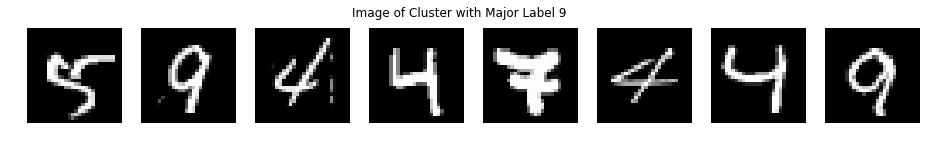

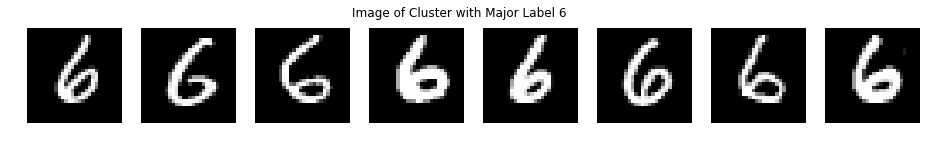

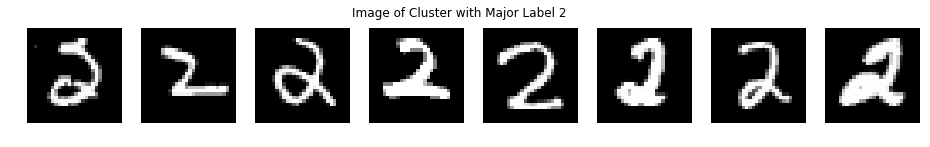

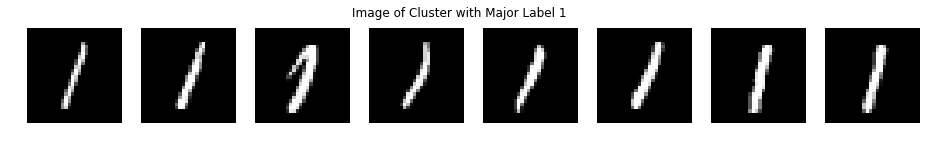

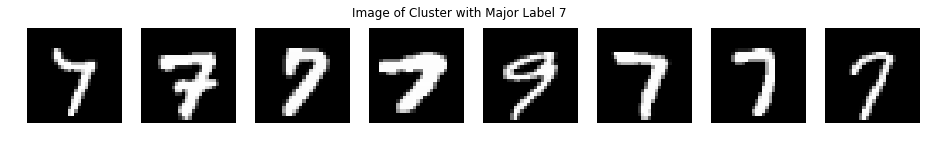

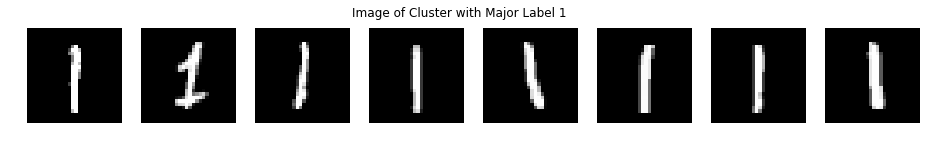

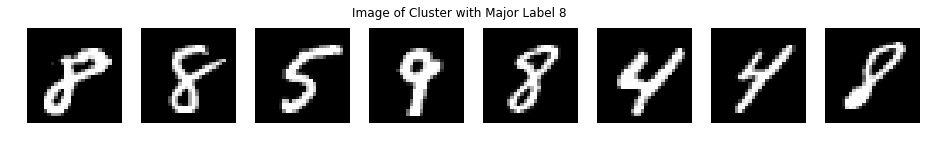

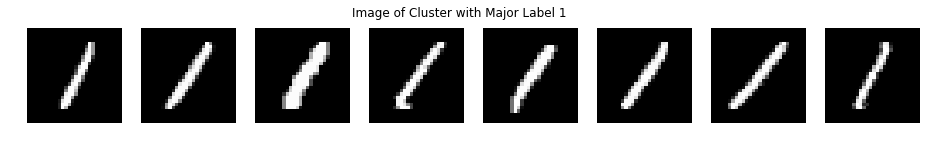

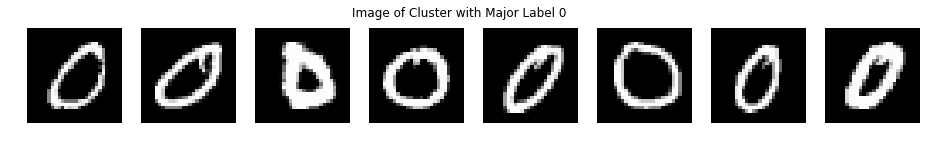

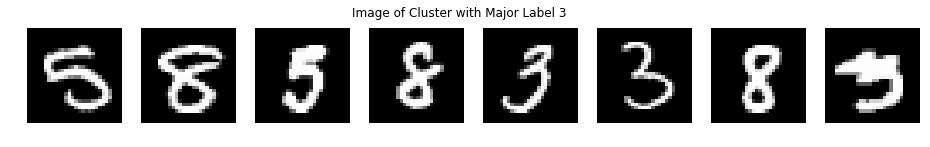

In [118]:
# Plot m sample images for each of the 10 clusters
for i in range(10):
    fig = plt.figure(figsize=(m*2,2))
    fig.suptitle('Image of Cluster with Major Label %d'%(MajorLabel[i]))
    for j in range(m):
        plt.subplot(1,m,j+1)
        temp=np.array(SmallTrain[RandomSampleIndex[i][j]])
        plt.imshow(temp.reshape((28,28)), cmap='gray')
        plt.axis('off') 
    plt.show() 

By comparing the result of spectral clustering with the result of standard K-means, I found that the spectral clustering does not work well. Since my labtop does not good enough to handle all of the data, I only use a partial of data so it does not fit well. If I can use all dataset, it can be improved.

In addition, the value of bandwidth largely affect to the clustering. I try several values of bandwidth. When the value is small, the cluster performance is really bad. If I can use an optimal bandwitdh value, the result will be better.

From the below test, I set tha value of bandwidth should be 30 for given small training set.

In [69]:
def SpectralErrorRate(Bandwidth,SmallTrain):
    h=Bandwidth
    sn=len(SmallTrain)
    AM=np.zeros(shape = (sn,sn))
    
    for i in range(0,sn):
        for j in range(i,sn):
            x1=SmallTrain[i]
            x2=SmallTrain[j]

            AM[i,j]=np.exp(-distance.euclidean(x1,x2)**2/h)
            AM[j,i] = AM[i,j]

    D_square=np.zeros(shape = (sn,sn))  #D^(1/2)
    for i in range(0,sn):
        D_square[i,i]=np.sqrt(sum(AM[i]))
    D_squareInv=inv(D_square)  #D^(1/2)^(-1)

    tW=np.dot(np.dot(D_square,AM),D_square)  #tilde(W) = D^(-1/2)WD^(1/2)
    L=np.eye(sn)-tW  #I-tilde(W)

    #The bottom few eigenvectors of L except the lowest one.
    [w, V] = np.linalg.eigh(L)
    BottomEigen=V[:,range(1,4)] #eigh module make e.vectors from low to high
    
    model=KMeans(n_clusters=10,init="random",n_init=1,max_iter=100,random_state=1)
    hand_cluster=model.fit(BottomEigen)
    hand_label=hand_cluster.labels_

    indexList=[]                   #Index of cluster label, from 0 to 9
    for i in range(0,10):
        kk=FindIndex(hand_label,i)
        indexList.append(kk)

    MajorLabel=[]
    for i in indexList:
        temp=[]
        for j in i:
            temp.append(SmallTrainLabel[j])   #Real Lable of element in each cluster
        MajorLabel.append(max(temp,key=temp.count))
        
    #Error rate in each cluster
    ErrorInCluster=[]
    NumberOfElement=[]
    for i in range(0,len(indexList)):
        cnt=0
        NumberOfElement.append(len(indexList[i]))
        for j in indexList[i]:
            if SmallTrainLabel[j] != MajorLabel[i]:  #If data label != Major label, error ++
                cnt+=1
        ErrorInCluster.append(round(cnt/len(indexList[i]),4))
    return(ErrorInCluster,NumberOfElement)

In [89]:
for i in range(10,101,4):
    EIC, NOE = SpectralErrorRate(i,SmallTrain)
    print("Bandwidth   : ",i)
    print("Error Rate  : ",EIC)
    print("# of element: ",NOE)
    print("Total Error : ",round(sum(EIC),4))
    print("Std(element): ",round(np.std(NOE),4),'\n\n')

Bandwidth   :  10
Error Rate  :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8584]
# of element:  [16, 3, 10, 14, 11, 7, 16, 11, 8, 904]
Total Error :  0.8584
Std(element):  268.0276 


Bandwidth   :  14
Error Rate  :  [0.0, 0.8625, 0.0, 0.0, 0.0, 0.7391, 0.7021, 0.0, 0.0, 0.0]
# of element:  [15, 829, 8, 30, 14, 23, 47, 18, 11, 5]
Total Error :  2.3037
Std(element):  243.2764 


Bandwidth   :  18
Error Rate  :  [0.0, 0.8217, 0.8326, 0.56, 0.0, 0.8151, 0.0, 0.6901, 0.0, 0.0]
# of element:  [7, 471, 221, 25, 14, 119, 21, 71, 21, 30]
Total Error :  3.7195
Std(element):  138.7573 


Bandwidth   :  22
Error Rate  :  [0.7548, 0.8182, 0.73, 0.6226, 0.0, 0.7767, 0.7368, 0.7083, 0.0, 0.0]
# of element:  [314, 242, 100, 53, 34, 103, 19, 72, 29, 34]
Total Error :  5.1474
Std(element):  94.486 


Bandwidth   :  26
Error Rate  :  [0.7743, 0.8088, 0.5902, 0.5636, 0.0, 0.66, 0.5, 0.6481, 0.0, 0.0]
# of element:  [350, 251, 61, 55, 37, 100, 28, 54, 29, 35]
Total Error :  4.545
Std(element):  104.

To evaluate spectral clustering, we need to check two issues.

1) The number of elements in each cluster are fairly even.

2) The error rates in each cluster are small.

As we know, spectral clustering algorithm is really sensitive to the value of bandwidth.

From the result, we can find that as the value of bandwidth increase, the number of element in each cluster are evenly distributed.

However, the total error rate usually increases as the value of bandwidth increases.

It may be caused by the small size of the training set. Since the running of this algorithm takes too long time, we only use 1000 dataset among 70000 dataset. If we can use more data, then the result will be better.

Otherwise, it is possible that given dataset does not fit to spectral clustering algorithm. As we discussed in past lectures, spectral clustering algorithm is useful when the data form unbalanced clusters.

Beside the two reasons, we can also think about unknown value of bandwidth.